In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq
import pickle as pkl
import pandas as pd
import umap.umap_ as umap

In [3]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [4]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
num_classes = len(info['label'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

/tmp/ipykernel_453854/1194137215.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))


Ensemble AUC: 0.995, Ensemble Accuracy: 0.936


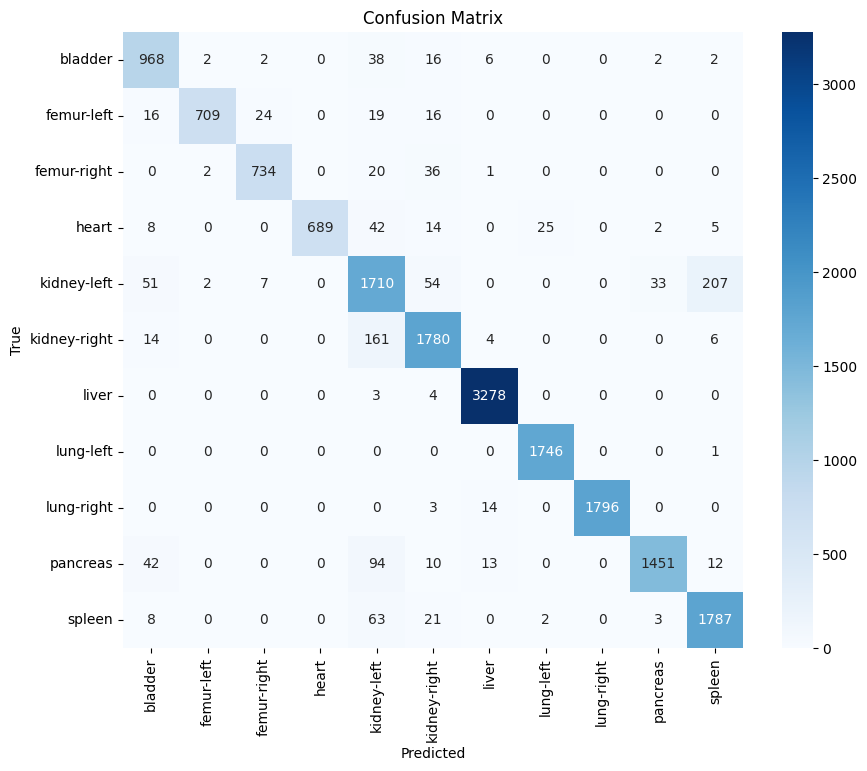

In [5]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

# Perform inference on the test set
y_true = []
y_scores = []
indiv_scores = [[], [], [], [], []]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true.extend(target.cpu().numpy().flatten())
        y_scores.extend(avg_output.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Evaluate the ensemble model
evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_scores)
print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

# Generate the confusion matrix

cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# Compute balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))
print(f'Balanced Accuracy: {balanced_acc:.3f}')

# Compute sensitivity (recall)
sensitivity = recall_score(y_true, y_scores.argmax(axis=1), average='macro')
print(f'Sensitivity: {sensitivity:.3f}')

# Compute specificity
cm = confusion_matrix(y_true, y_scores.argmax(axis=1))
# Number of classes
num_classes = cm.shape[0]

# Compute specificity for each class
specificities = []
for i in range(num_classes):
    FP = np.sum(cm[:, i]) - cm[i, i]  # False Positives: sum of column i, excluding diagonal
    TN = np.sum(cm) - (np.sum(cm[i, :]) + FP)  # True Negatives: everything else
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 1.0  # Avoid division by zero
    specificities.append(specificity)

# Compute macro specificity
macro_specificity = np.mean(specificities)

# Compute standard deviation of specificity
specificity_sd = np.std(specificities)

# Compute standard deviation of balanced accuracy
balanced_accs = []
for i in range(num_classes):
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_scores.argmax(axis=1) == i).astype(int)
    balanced_accs.append(balanced_accuracy_score(y_true_binary, y_pred_binary))
balanced_acc_sd = np.std(balanced_accs)

# Compute standard deviation of sensitivity
sensitivities = []
for i in range(num_classes):
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_scores.argmax(axis=1) == i).astype(int)
    sensitivities.append(recall_score(y_true_binary, y_pred_binary))
sensitivity_sd = np.std(sensitivities)

# Compute standard deviation of AUC
aucs = []
for i in range(num_classes):
    y_true_binary = (y_true == i).astype(int)
    y_score_binary = y_scores[:, i]
    aucs.append(roc_auc_score(y_true_binary, y_score_binary))
auc_sd = np.std(aucs)

# Print results
print(f"Macro-Averaged Specificity: {macro_specificity:.4f}")
print(f"Standard Deviation of Specificity: {specificity_sd:.4f}")
print(f"Standard Deviation of Balanced Accuracy: {balanced_acc_sd:.4f}")
print(f"Standard Deviation of Sensitivity: {sensitivity_sd:.4f}")
print(f"Standard Deviation of AUC: {auc_sd:.4f}")

Balanced Accuracy: 0.928
Sensitivity: 0.928
Macro-Averaged Specificity: 0.9935
Standard Deviation of Specificity: 0.0083
Standard Deviation of Balanced Accuracy: 0.0281
Standard Deviation of Sensitivity: 0.0513
Standard Deviation of AUC: 0.0052


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

train_dataset = DataClass(split='train', download=download, transform=transform)
val_dataset = DataClass(split='val', download=download, transform=transform)

# Combine train_dataset and val_dataset
combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Set the random seed for reproducibility
torch.manual_seed(42)

# Calculate the sizes for training and calibration datasets
train_size = int(0.8 * len(combined_train_dataset))
calibration_size = len(combined_train_dataset) - train_size

# Split the combined_train_dataset into training and calibration datasets
train_dataset, calibration_dataset = random_split(combined_train_dataset, [train_size, calibration_size])

# Create DataLoaders for the new training and calibration datasets
calibration_loader = DataLoader(dataset=calibration_dataset, batch_size=128, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calibration_dataset)}')

Training dataset size: 32841
Calibration dataset size: 8211


In [8]:
# Create stratified K-fold cross-validator
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get the labels for stratification
labels = [label for _, label in train_dataset]

# Create a list to store the new dataloaders
train_loaders = []
val_loaders = []

for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)
    
    train_loader = DataLoader(dataset=train_subset, batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=128, shuffle=True, drop_last=True)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

/tmp/ipykernel_453854/3139380480.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
/tmp/ipykernel_453854/3139380480.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob_calibration = np.array(F.softmax(torch.tensor(y_scores_calibration), dim=1))


Calibration AUC: 1.000, Calibration Accuracy: 0.998, Calibration Balanced Accuracy: 0.997


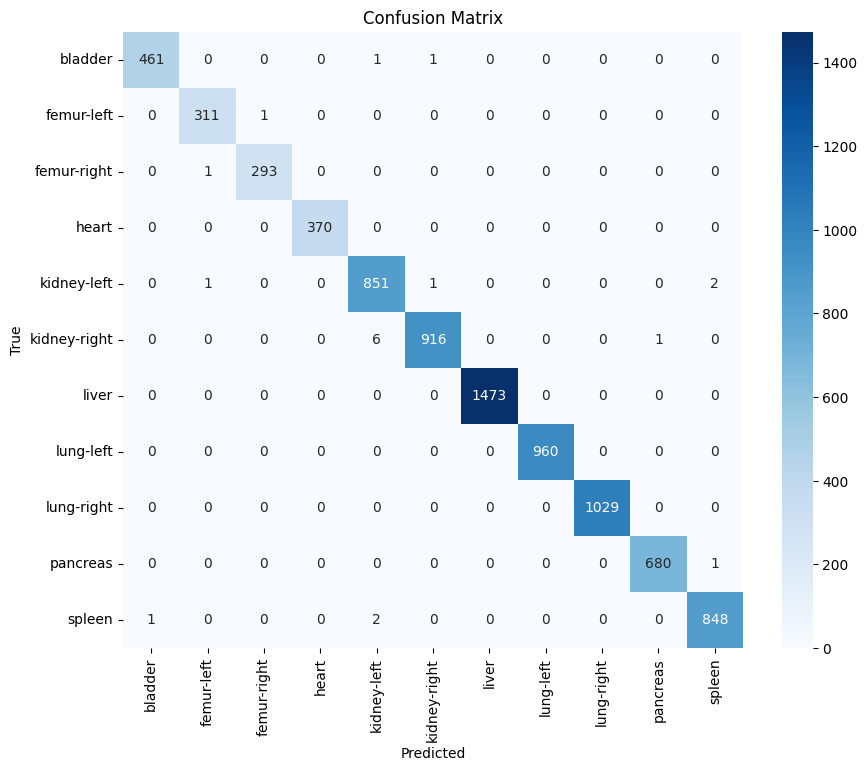

In [9]:
# Perform inference on the test set
y_true_calibration = []
y_scores_calibration = []
indiv_scores_calibration = [[], [], [], [], []]

with torch.no_grad():
    for data, target in calibration_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores_calibration, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true_calibration.extend(target.cpu().numpy().flatten())
        y_scores_calibration.extend(avg_output.cpu().numpy())

y_true_calibration = np.array(y_true_calibration)
y_scores_calibration = np.array(y_scores_calibration)
y_prob_calibration = np.array(F.softmax(torch.tensor(y_scores_calibration), dim=1))
# Compute AUC, Accuracy, and Balanced Accuracy for the calibration dataset

# Compute AUC
auc_calibration = roc_auc_score(y_true_calibration, y_prob_calibration, multi_class='ovr')

# Compute Accuracy
acc_calibration = accuracy_score(y_true_calibration, y_prob_calibration.argmax(axis=1))

# Compute Balanced Accuracy
bacc_calibration = balanced_accuracy_score(y_true_calibration, y_prob_calibration.argmax(axis=1))

print(f'Calibration AUC: {auc_calibration:.3f}, Calibration Accuracy: {acc_calibration:.3f}, Calibration Balanced Accuracy: {bacc_calibration:.3f}')

# Generate the confusion matrix
cm = confusion_matrix(y_true_calibration, y_scores_calibration.argmax(axis=1))
# 
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))

/tmp/ipykernel_453854/2939530776.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))


In [11]:
correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

In [12]:
def find_best_threshold_and_compute_metrics(values, correct_predictions):
    # Function to compute metrics
    def compute_metrics(uq_values, labels, threshold):
        predictions = (uq_values <= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        balanced_acc = balanced_accuracy_score(labels, predictions)
        return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

    # Function to find the optimal threshold
    def find_optimal_threshold(uq_values, labels):
        thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
        best_threshold = thresholds[0]
        best_balanced_acc = 0
        for threshold in thresholds:
            _, _, _, _, _, _, balanced_acc = compute_metrics(uq_values, labels, threshold)
            if balanced_acc > best_balanced_acc:
                best_balanced_acc = balanced_acc
                best_threshold = threshold
        return best_threshold

    # Find the optimal threshold
    labels = np.array([1 if i in correct_predictions else 0 for i in range(len(values))])
    optimal_threshold = find_optimal_threshold(values, labels)

    # Compute the confusion matrix using the optimal threshold
    predictions = (values <= optimal_threshold).astype(int)
    cm = confusion_matrix(labels, predictions)
    

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the optimal threshold and balanced accuracy
    _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(values, labels, optimal_threshold)
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")

In [13]:
class ClassifierHeadWrapper(nn.Module):
    def __init__(self, model):
        super(ClassifierHeadWrapper, self).__init__()
        self.fc = model.fc  # Replace 'fc2' with the appropriate layer name

    def forward(self, x):
        return self.fc(x)

In [14]:
from torchsummary import summary

# Assuming 'model' is an instance of your ResNet18 class
model = ResNet18(num_classes=num_classes).to(device)

# Print the summary of the model
summary(model, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [15]:
# models = [model.to(device) for model in models]
# latent_spaces = []
# shap_values_folds = []
# success_folds = []
# for fold in range(0, 5):
#     print('fold n' + str(fold))
#     classifier_head = ClassifierHeadWrapper(models[fold].model).to(device)
#     # Compute SHAP values for the penultimate layer
#     shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
#         model=models[fold],
#         data_loader=test_loader,
#         device=device,
#         layer_to_be_hooked=models[fold].model.avgpool,
#         classifierheadwrapper=classifier_head,
#         shap_explainer='DeepExplainer',
#         max_background_samples=50
#     )
#     latent_spaces.append(shap_features)
#     shap_values_folds.append(shap_values)
#     success_folds.append(success.squeeze() if success.ndim > 1 else success)

In [23]:
# Load the SHAP results from the pickle file
with open('shap_results_calibration.pkl', 'rb') as file:
    shap_results_calibration = pkl.load(file)

In [35]:
mean_shap_importances = []
for fold, shap_values in enumerate(shap_results_calibration['shap_values_folds']):
    mean_shap_fold = uq.compute_mean_shap_values(shap_values, fold, 50)
    mean_shap_importances.append(mean_shap_fold)

SHAP Feature Importances Computation
Class 0: SHAP Feature Importances
Feature_95     0.114923
Feature_387    0.105968
Feature_370    0.093839
Feature_385    0.092621
Feature_105    0.091537
Feature_269    0.089927
Feature_394    0.087709
Feature_209    0.086547
Feature_383    0.082337
Feature_292    0.081523
Feature_481    0.081200
Feature_56     0.080973
Feature_198    0.079193
Feature_358    0.075686
Feature_362    0.075651
Feature_39     0.075231
Feature_118    0.073360
Feature_406    0.071006
Feature_344    0.070240
Feature_264    0.068847
Feature_86     0.068594
Feature_57     0.067829
Feature_50     0.067809
Feature_506    0.066845
Feature_443    0.065944
Feature_499    0.065868
Feature_487    0.065180
Feature_285    0.061954
Feature_23     0.061858
Feature_210    0.061051
Feature_13     0.060939
Feature_322    0.060721
Feature_265    0.060370
Feature_197    0.059848
Feature_113    0.059547
Feature_304    0.059141
Feature_83     0.058853
Feature_217    0.058369
Feature_343    0.

In [36]:
latent_spaces_df = []
for fold, latent_space in enumerate(shap_results_calibration['latent_spaces']):
    num_samples, num_features = latent_space.shape
    latent_space_df = pd.DataFrame(
        latent_space,
        columns=[f"Feature_{i}" for i in range(num_features)]
    )
    latent_spaces_df.append(latent_space_df)

In [37]:
plt.close('all')
successes_folds = []
knn_distances_folds = []

for fold in range(5):
    knn_distances_all, successes_all = uq.compute_knn_distances_to_train_data(models[fold], train_loaders[fold], test_loader, models[fold].model.avgpool, device, latent_spaces_df[fold], mean_shap_importances[fold], 11)
    knn_distances_folds.append(knn_distances_all)
    successes_folds.append(successes_all)

class0
Number of samples with true label 0: 1450
Number of samples with true label 0: 1036
class1
Number of samples with true label 1: 1048
Number of samples with true label 1: 784
class2
Number of samples with true label 2: 1030
Number of samples with true label 2: 793
class3
Number of samples with true label 3: 1197
Number of samples with true label 3: 785
class4
Number of samples with true label 4: 2935
Number of samples with true label 4: 2064
class5
Number of samples with true label 5: 2821
Number of samples with true label 5: 1965
class6
Number of samples with true label 6: 4576
Number of samples with true label 6: 3285
class7
Number of samples with true label 7: 3187
Number of samples with true label 7: 1747
class8
Number of samples with true label 8: 3125
Number of samples with true label 8: 1813
class9
Number of samples with true label 9: 2300
Number of samples with true label 9: 1622
class10
Number of samples with true label 10: 2571
Number of samples with true label 10: 1884

In [38]:
# Calculate the mean of the lists inside knn_distances_folds
mean_knn_distances = np.mean(knn_distances_folds, axis=0)

# Print the result
print(mean_knn_distances)

[1.88263382e+00 1.60999319e-01 8.39277979e-02 ... 8.70932322e+01
 4.59719987e+00 4.57756210e+00]


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:409: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


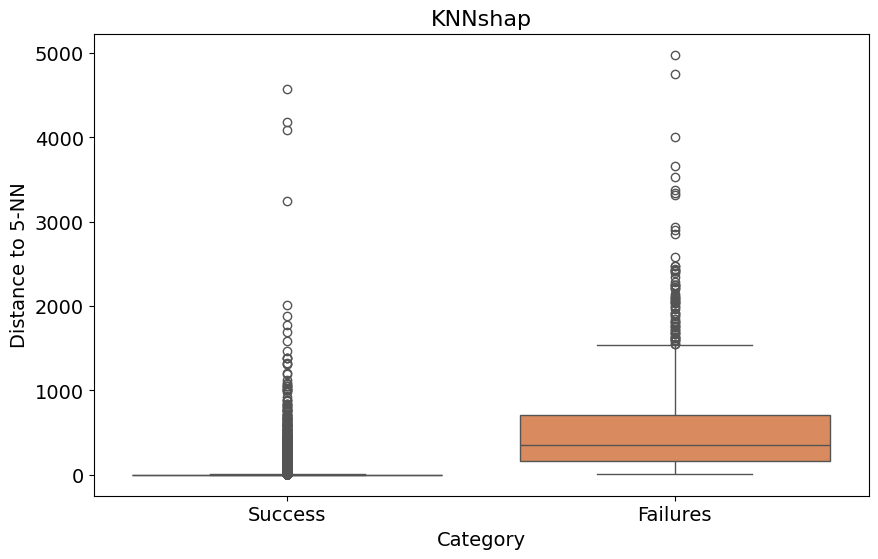

In [28]:
uq.UQ_method_plot([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions], 'Distance to 5-NN', 'KNNshap', swarmplot=False)

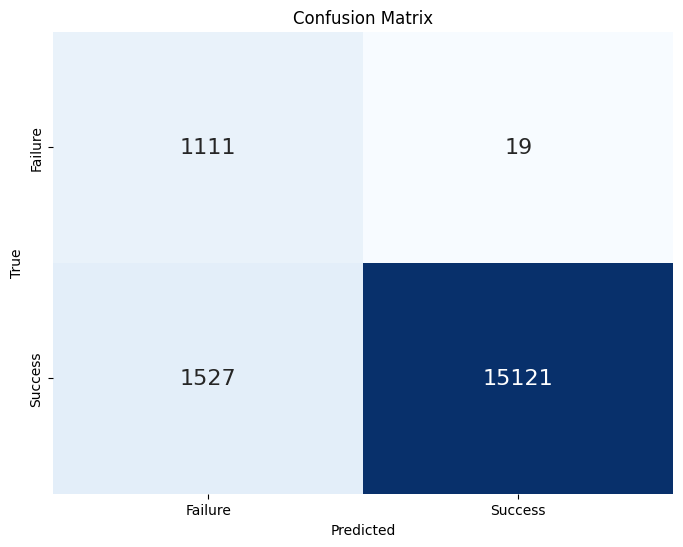

Optimal Threshold: 24.953376897867184
Balanced Accuracy: 0.9457315556254864
Specificity: 0.9831858407079646
Sensitivity: 0.9082772705430082


In [29]:
find_best_threshold_and_compute_metrics(mean_knn_distances, correct_predictions)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:405: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


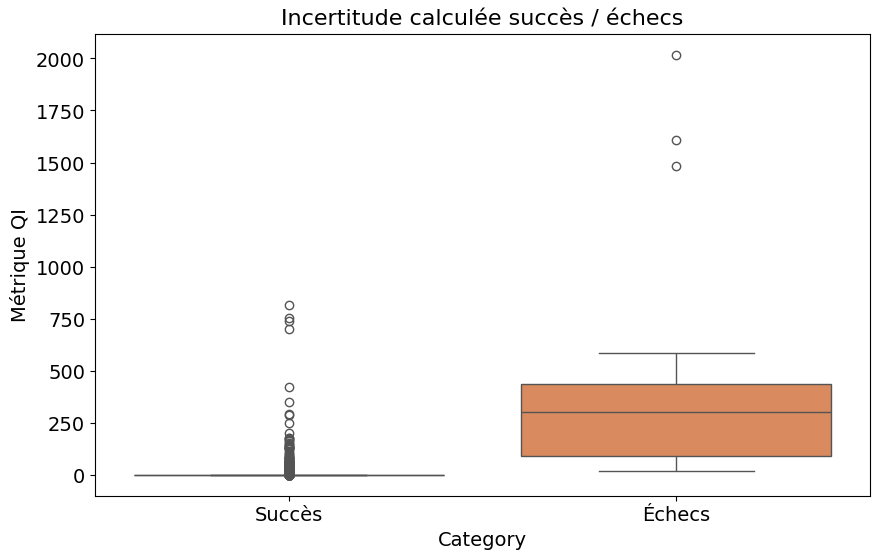

In [29]:
uq.UQ_method_plot([mean_knn_distances_calibration[k] for k in correct_predictions_calibration], [mean_knn_distances_calibration[j] for j in incorrect_predictions_calibration], 'Métrique QI', 'Incertitude calculée succès / échecs', swarmplot=False)

In [30]:
fpr_std_knn, tpr_std_knn, auc_std_knn = uq.roc_curve_UQ_method_computation([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions])

In [31]:
auc_std_knn

np.float64(0.9796481971312295)

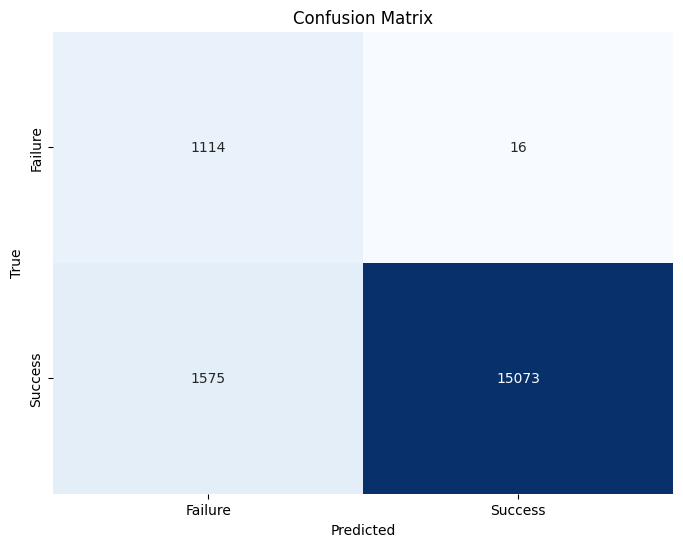

Optimal Threshold: 23.84833381183355
Balanced Accuracy: 0.946
Specificity: 0.986
Sensitivity: 0.905


In [33]:
find_best_threshold_and_compute_metrics(mean_knn_distances, correct_predictions)

In [30]:
knn_distances_all = []
for fold in range(5):
    successes = []
    knn_distances = []
    indices = []
    
    latent_space_training, labels_training, success_training, preds_training = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    
    latent_space_test, labels_test, success_test, preds_test = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    
    train_latent_space = pd.DataFrame(latent_space_training, columns=latent_spaces_df[fold].columns)
    test_latent_space = pd.DataFrame(latent_space_test, columns=latent_spaces_df[fold].columns)
        
        
    scaler = StandardScaler()
    train_latent_space_standardized = scaler.fit_transform(train_latent_space)
    
    pca = PCA(n_components=0.9)
    train_latent_space_pca = pca.fit_transform(train_latent_space_standardized)
    
    test_latent_space_standardized = scaler.transform(test_latent_space)
    test_latent_space_pca = pca.transform(test_latent_space_standardized)
    
    knn = NearestNeighbors(n_neighbors=5)
    knn.fit(train_latent_space_pca)
    distances, _ = knn.kneighbors(test_latent_space_pca)
    
    average_distances = distances.mean(axis=1)
    
    knn_distances_all.append(average_distances)

In [ ]:
# Calculate the mean of the lists inside knn_distances_folds
mean_knn_distances_all_features = np.mean(knn_distances_all, axis=0)


[2.00565562 1.26888467 0.13590734 ... 2.11035632 1.35398712 1.064454  ]


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:409: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


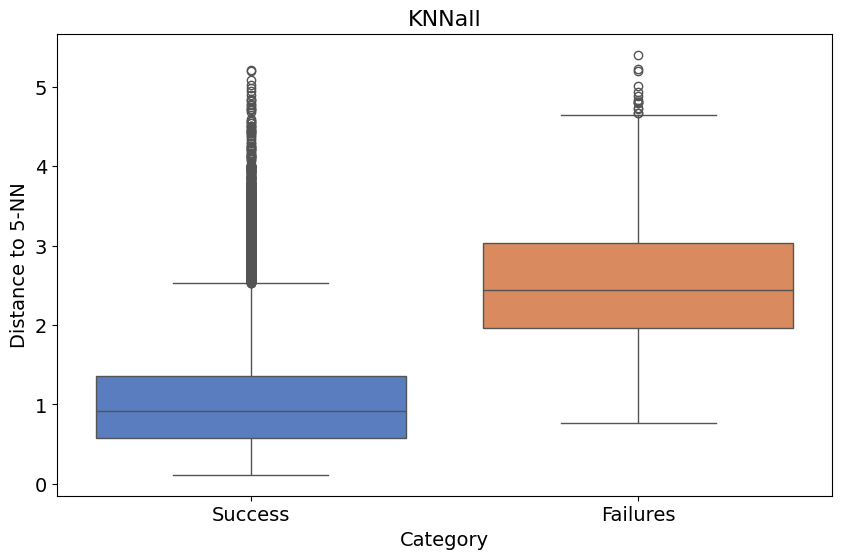

In [ ]:
uq.UQ_method_plot([mean_knn_distances_all_features[k] for k in correct_predictions], [mean_knn_distances_all_features[j] for j in incorrect_predictions], 'Distance to 5-NN', 'KNNall', swarmplot=False)

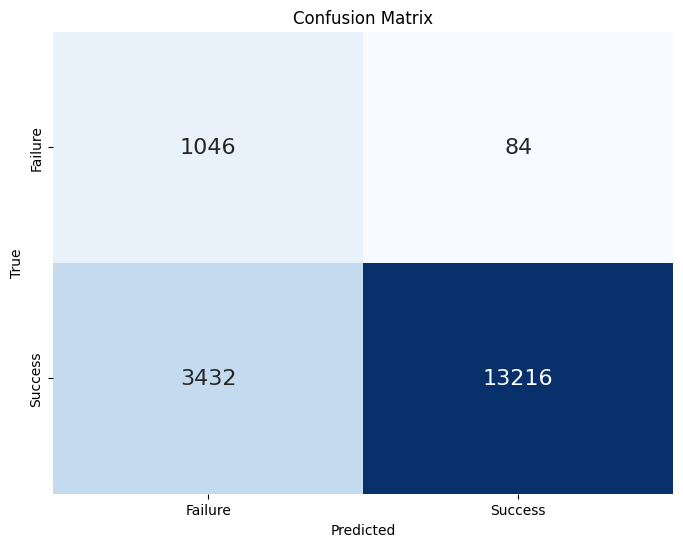

Optimal Threshold: 1.5020430068886421
Balanced Accuracy: 0.8597564139092421
Specificity: 0.9256637168141593
Sensitivity: 0.7938491110043249


In [33]:
find_best_threshold_and_compute_metrics(mean_knn_distances, correct_predictions)

In [ ]:
fpr_std_knn, tpr_std_knn, auc_std_knn = uq.roc_curve_UQ_method_computation([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions])

In [ ]:
auc_std_knn

In [ ]:
mean_shap_importances = []
for fold, shap_values in enumerate(shap_results['shap_values_folds']):
    print(f"Fold {fold}: SHAP Feature Importances")

    # Ensure shap_values is a 2D array
    num_samples, num_features = shap_values.shape

    # Create a DataFrame for SHAP values
    shap_df = pd.DataFrame(
        shap_values,
        columns=[f"Feature_{i}" for i in range(num_features)]
    )
    
    shap_importance = uq.display_shap_values(shap_df)
    print(shap_importance)
    mean_shap_importances.append(shap_importance)

In [ ]:
latent_spaces_df = []
for fold, latent_space in enumerate(shap_results['latent_spaces']):
    num_samples, num_features = latent_space.shape
    latent_space_df = pd.DataFrame(
        latent_space,
        columns=[f"Feature_{i}" for i in range(num_features)]
    )
    latent_spaces_df.append(latent_space_df)

In [ ]:
plt.close('all')
for fold, shap_importance in enumerate(mean_shap_importances):
    uq.plot_shap_importance(shap_importance, fold)


In [ ]:
# Plot for each fold
for fold, features in enumerate(shap_results['latent_spaces']):
    uq.plot_clustered_feature_heatmap(features, fold)

In [ ]:
plt.close('all')
reduced_latent_spaces = []
selected_features = []
distances_folds = []
preds_folds = []

for fold in range(0,5):
    final_latent_space, final_features = uq.feature_engineering_pipeline(
        mean_shap_df=mean_shap_importances[fold],
        latent_space=latent_spaces_df[fold],
        shap_threshold=0.04,
        corr_threshold=0.8)
    reduced_latent_spaces.append(final_latent_space)
    selected_features.append(final_features)
    
    uq.plot_shap_importance(mean_shap_importances[fold], fold, final_features)

    latent_space_training, labels_training, success_training, preds_training = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    train_latent_space = pd.DataFrame(latent_space_training, columns=latent_spaces_df[fold].columns)
    
    latent_space_test, labels_test, success_test, preds_test = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    preds_folds.append(preds_test)
    test_latent_space = pd.DataFrame(latent_space_test, columns=latent_spaces_df[fold].columns)
    
    train_latent_space = train_latent_space[final_features]
    test_latent_space = test_latent_space[final_features]
    normalized_latent_space_train = (train_latent_space - train_latent_space.mean(axis=0)) / train_latent_space.std(axis=0)
    normalized_latent_space_test = (test_latent_space - test_latent_space.mean(axis=0)) / test_latent_space.std(axis=0)

    # Convert labels to a 1D array
    labels_train_fold = labels_training.flatten()
    labels_test_fold = labels_test.flatten()
    # Initialize UMAP
    reducer = umap.UMAP(n_components=2, n_neighbors=1000, random_state=42)

    # Fit and transform the latent space
    embedding = reducer.fit_transform(np.array(normalized_latent_space_train))
    embedding_test = reducer.transform(np.array(normalized_latent_space_test))

    # Plot the UMAP embedding
    plt.figure(figsize=(20, 16))
    sns.kdeplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels_train_fold, palette='Spectral', fill=True, thresh=0.05)

    # Overlay the test data
    success_colors = ['red' if success == 0 else 'green' for success in success_test]
    plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors,  alpha=0.3, s=10)

    plt.title('UMAP projection of the latent space')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()
    
    # Visualize UMAP
    #uq.visualize_umap_with_labels(train_umap, test_umap, success_test, labels, fold=fold)

In [ ]:
latent_spaces_training = []
success_folds_training = []
labels_all_training = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    # Compute SHAP values for the penultimate layer
    latent_space_training, labels_training, success_training, preds_training = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    latent_spaces_training.append(latent_space_training)
    success_folds_training.append(success_training)
    labels_all_training.append(labels_training)

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Convert labels_all[0] to a 1D array
labels_0 = labels_all_training[0].flatten()
labels_test_0 = labels_all[0].flatten()
# Initialize UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=1000, random_state=42)

# Fit and transform the latent space
embedding = reducer.fit_transform(latent_spaces_training[0].cpu().numpy())
embedding_test = reducer.transform(latent_spaces[0].cpu().numpy())

In [ ]:
# Plot the UMAP embedding
plt.figure(figsize=(20, 16))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_0, cmap='Spectral', s=20)
plt.colorbar(scatter, ticks=range(num_classes), label='Classes')

# Overlay the test data
success_colors = ['red' if success == 0 else 'green' for success in success_folds[0]]
plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors, s=10, alpha=0.3)

plt.title('UMAP projection of the latent space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
# Plot the UMAP embedding using KDE plot for training data
plt.figure(figsize=(15, 12))
sns.kdeplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels_0, palette='Spectral', fill=True, thresh=0.05)

# Overlay the test data
success_colors = ['red' if success == 0 else 'green' for success in success_folds[0]]
plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors,  alpha=0.3, s=10)

plt.title('UMAP projection of the latent space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
# Check unique labels in training data
unique_labels_training = np.unique(labels_all_training[0])
print("Unique labels in training data:", unique_labels_training)

# Check unique labels in test data
unique_labels_test = np.unique(labels_all[0])
print("Unique labels in test data:", unique_labels_test)

In [14]:
tta_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandAugment(2, 9),
                    transforms.PILToTensor(),
                    transforms.ConvertImageDtype(torch.float)
                ])

crops_flips_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=49, scale=(0.8, 1.0)),  # Random crop with resizing
    transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
    transforms.RandomRotation(degrees=180),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [15]:
stds_TTA, global_preds_TTA = uq.TTA(tta_transform, models, test_loader, device, nb_augmentations=5, nb_channels=3, softmax_application=True, usingBetterRandAugment=False)
stds_RT, global_preds_RT = uq.TTA(crops_flips_transforms, models, test_loader, device, nb_augmentations=5, nb_channels=3, softmax_application=True)

Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3
Applying augmentation n : 4
Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3
Applying augmentation n : 4


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:409: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


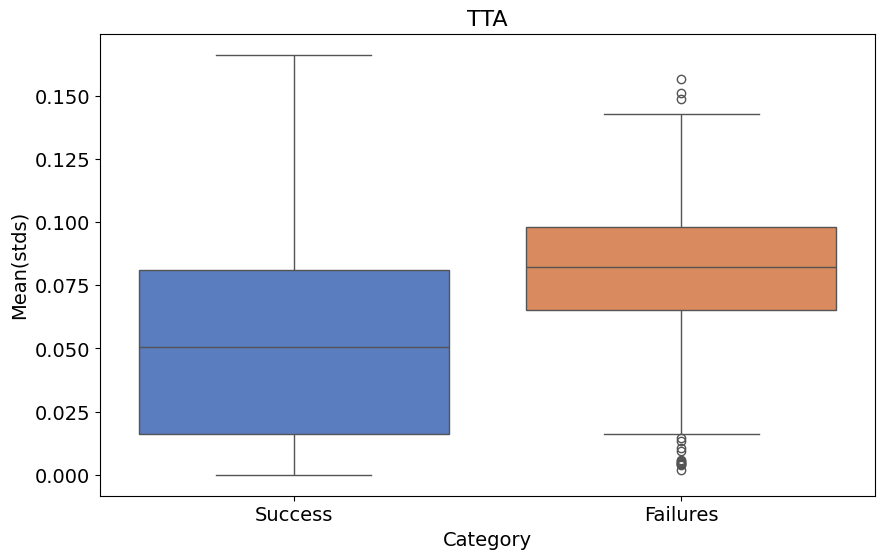

In [16]:
uq.UQ_method_plot([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions], 'Mean(stds)', 'TTA', swarmplot=False)

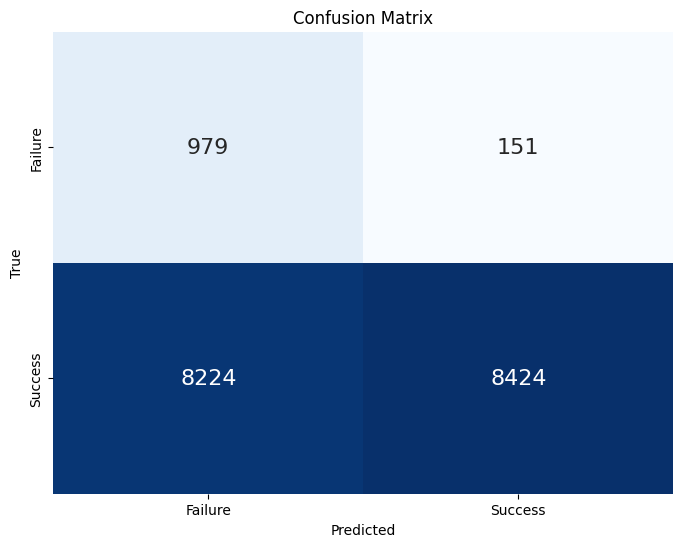

Optimal Threshold: 0.05160622154757364
Balanced Accuracy: 0.6861892044753841
Specificity: 0.8663716814159292
Sensitivity: 0.506006727534839


In [17]:
find_best_threshold_and_compute_metrics(stds_TTA, correct_predictions)

In [ ]:
fpr_std_rt, tpr_std_rt, auc_std_rt = uq.roc_curve_UQ_method_computation([stds_RT[k] for k in correct_predictions], [stds_RT[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_RT[k] for k in correct_predictions], [stds_RT[j] for j in incorrect_predictions], 'Stds', 'TTA', swarmplot=False)

In [ ]:
fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions], 'Stds', 'TTA', swarmplot=False)

In [ ]:
#uq.apply_randaugment_and_store_results(calibration_loader, models, 2, 45, 500, device, folder_name=f'savedpolicies', batch_norm=True, image_size=28, nb_channels=3, softmax_application=True)

In [34]:
best_aug = uq.perform_greedy_policy_search('savedpolicies', correct_predictions_calibration, incorrect_predictions_calibration, num_workers=90, max_iterations=30, num_searches=30, top_k=5, plot=True)
n, m, transformations = uq.extract_gps_augmentations_info(best_aug)

Loading predictions...


KeyboardInterrupt: 

In [18]:
transformations = ['[(9, np.float64(18.993544968225756)), (12, np.float64(-1.372124799393923))]',
 '[(9, np.float64(13.796092578543764)), (13, np.float64(9.650253122391298))]',
 '[(9, np.float64(26.753347976507428)), (4, np.float64(-2.269870568517014))]',
 '[(10, np.float64(1.7976877272614402)), (14, np.float64(-2.253227258808664))]',
 '[(11, np.float64(-7.330877383517148)), (13, np.float64(17.226544341423256))]']
n=2
m=45

In [19]:
stds_GPS, global_preds_GPS = uq.TTA(transformations, models, test_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, batch_norm=True, softmax_application=True)

Manually set transform. Current transform: 
[(9,np.float64(18.993544968225756)),(12,np.float64(-1.372124799393923))]
Manually set transform. Current transform: 
[(9,np.float64(13.796092578543764)),(13,np.float64(9.650253122391298))]
Manually set transform. Current transform: 
[(9,np.float64(26.753347976507428)),(4,np.float64(-2.269870568517014))]
Manually set transform. Current transform: 
[(10,np.float64(1.7976877272614402)),(14,np.float64(-2.253227258808664))]
Manually set transform. Current transform: 
[(11,np.float64(-7.330877383517148)),(13,np.float64(17.226544341423256))]
Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3
Applying augmentation n : 4


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:409: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


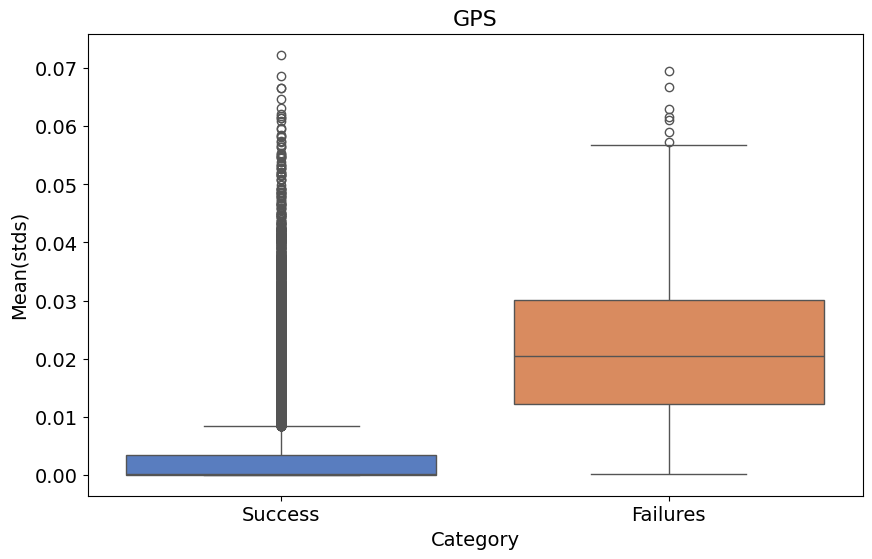

In [20]:
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in correct_predictions], [stds_GPS[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_GPS[k] for k in correct_predictions], [stds_GPS[j] for j in incorrect_predictions], 'Mean(stds)', 'GPS', swarmplot=False)

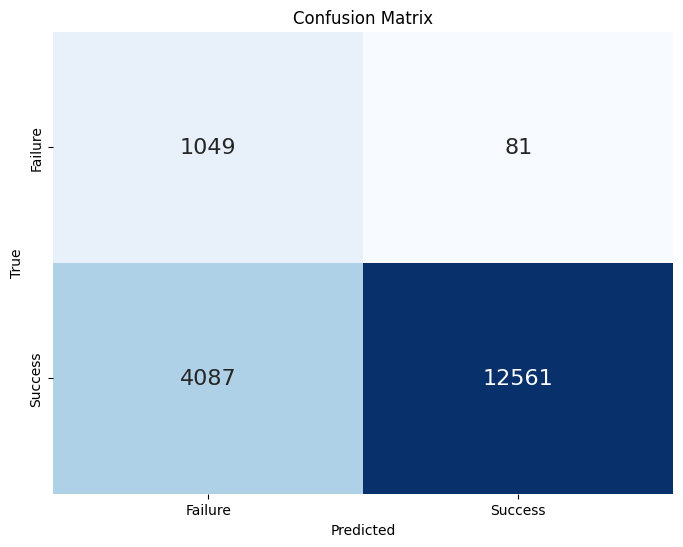

Optimal Threshold: 0.0036203673710484175
Balanced Accuracy: 0.8414118148609628
Specificity: 0.9283185840707965
Sensitivity: 0.7545050456511293


In [21]:
find_best_threshold_and_compute_metrics(stds_GPS, correct_predictions)

In [22]:
auc_std_gps

np.float64(0.9068208783217734)

In [ ]:
best_aug_calibration = uq.perform_greedy_policy_search('savedpolicies_testset', correct_predictions, incorrect_predictions, num_workers=90, max_iterations=30, num_searches=30, top_k=5, plot=True)
n, m, transformations_calibration = uq.extract_gps_augmentations_info(best_aug_calibration)

In [39]:
transformations_calibration = ['[(13, np.float64(9.826685866454547)), (11, np.float64(-1.9805003878025786))]',
 '[(9, np.float64(1.804627907095039)), (12, np.float64(-1.3265139396701287))]',
 '[(9, np.float64(-21.201456998141612)), (0, np.float64(28.024478487844902))]',
 '[(10, np.float64(-6.385809050023269)), (10, np.float64(12.903347343792575))]',
 '[(11, np.float64(-8.335989058024602)), (13, np.float64(-3.0399266781252194))]']

In [40]:
stds_GPS_calibration, global_preds_GPS_calibration = uq.TTA(transformations_calibration, models, calibration_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, batch_norm=True, softmax_application=True)

Manually set transform. Current transform: 
[(13,np.float64(9.826685866454547)),(11,np.float64(-1.9805003878025786))]
Manually set transform. Current transform: 
[(9,np.float64(1.804627907095039)),(12,np.float64(-1.3265139396701287))]
Manually set transform. Current transform: 
[(9,np.float64(-21.201456998141612)),(0,np.float64(28.024478487844902))]
Manually set transform. Current transform: 
[(10,np.float64(-6.385809050023269)),(10,np.float64(12.903347343792575))]
Manually set transform. Current transform: 
[(11,np.float64(-8.335989058024602)),(13,np.float64(-3.0399266781252194))]
Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3
Applying augmentation n : 4


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:405: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


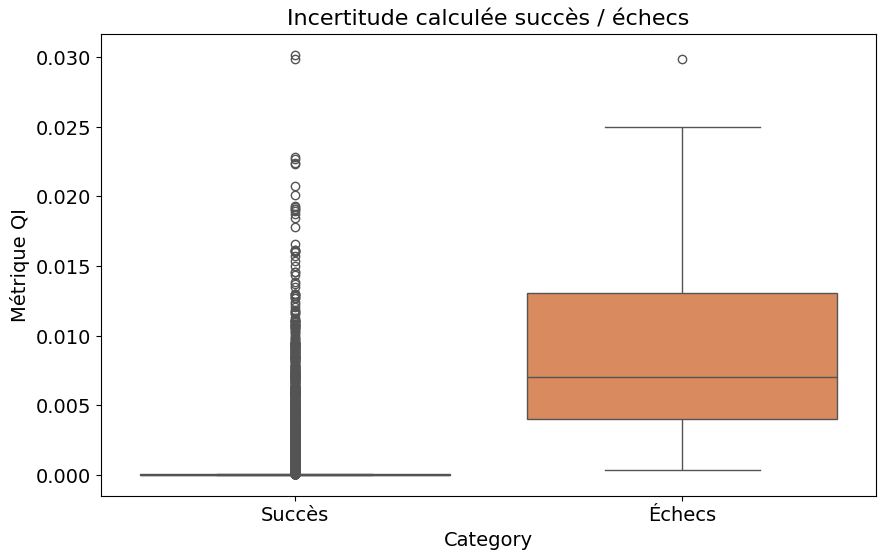

In [41]:
fpr_std_gps_calibration, tpr_std_gps_calibration, auc_std_gps_calibration = uq.roc_curve_UQ_method_computation([stds_GPS_calibration[k] for k in correct_predictions_calibration], [stds_GPS_calibration[j] for j in incorrect_predictions_calibration])
uq.UQ_method_plot([stds_GPS_calibration[k] for k in correct_predictions_calibration], [stds_GPS_calibration[j] for j in incorrect_predictions_calibration], 'Métrique QI', 'Incertitude calculée succès / échecs', swarmplot=False)

In [14]:
distances = uq.distance_to_hard_labels_computation(y_prob)
distances_calibration = uq.distance_to_hard_labels_computation(y_prob_calibration)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


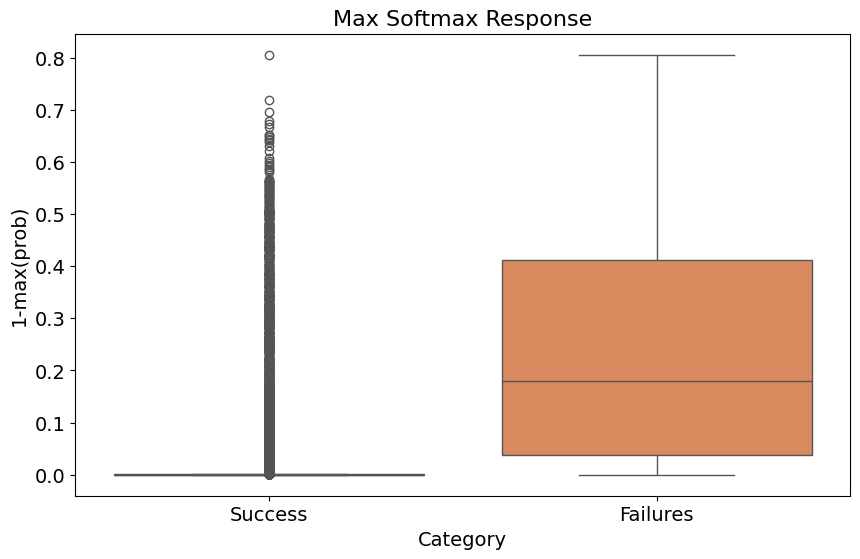

In [15]:
uq.UQ_method_plot([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions], '1-max(prob)', 'Max Softmax Response', swarmplot=False)

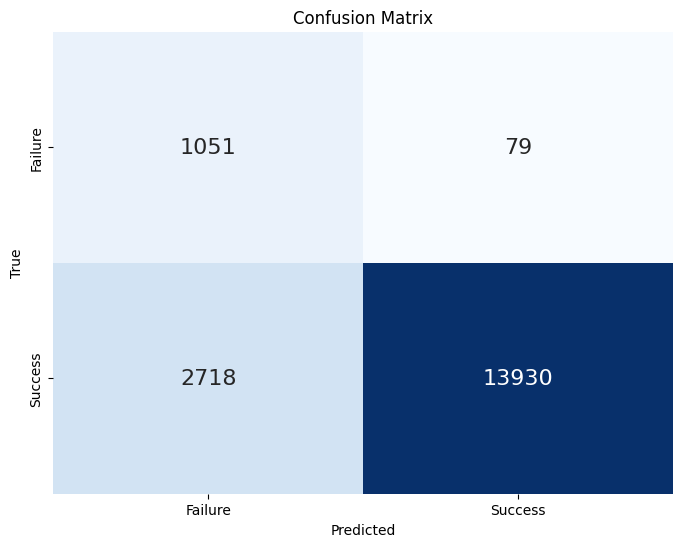

Optimal Threshold: 0.0024187033995985985
Balanced Accuracy: 0.8834128205891483
Specificity: 0.9300884955752212
Sensitivity: 0.8367371456030754


In [20]:
find_best_threshold_and_compute_metrics(distances, correct_predictions)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


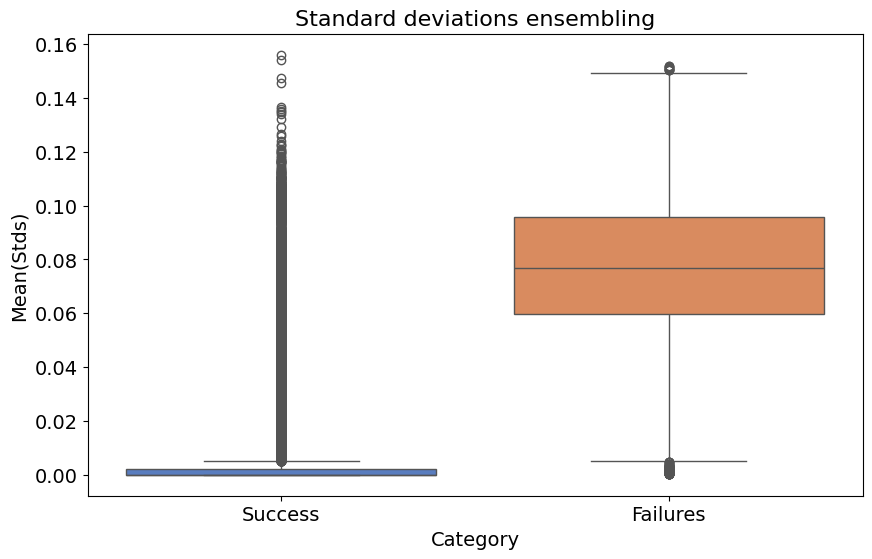

In [22]:
stds = uq.ensembling_stds_computation(indiv_scores)
stds_calibration = uq.ensembling_stds_computation(indiv_scores_calibration)
uq.UQ_method_plot([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions], 'Mean(Stds)', 'Standard deviations ensembling', swarmplot=False)

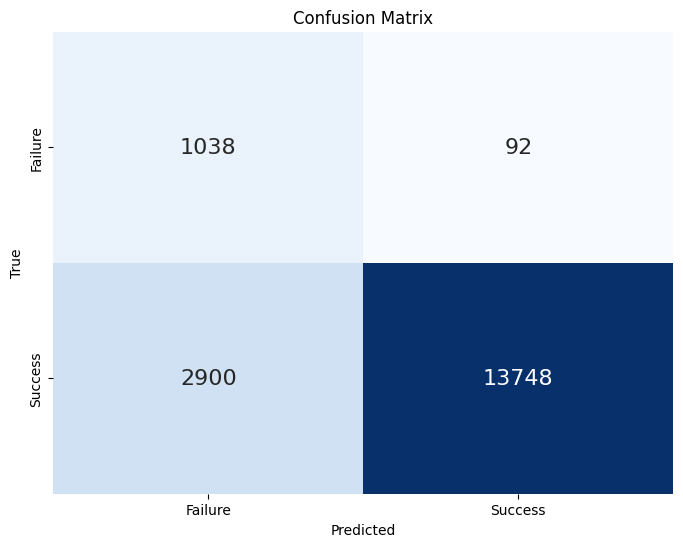

Optimal Threshold: 0.011876114644110203
Balanced Accuracy: 0.8721944861430644
Specificity: 0.9185840707964602
Sensitivity: 0.8258049014896685


In [23]:
find_best_threshold_and_compute_metrics(stds, correct_predictions)

In [ ]:
fpr_distance_to_hard_labels, tpr_distance_to_hard_labels, auc_distance_to_hard_labels = uq.roc_curve_UQ_method_computation([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions])
fpr_stds, tpr_stds, auc_stds = uq.roc_curve_UQ_method_computation([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions])
fpr_std_knn, tpr_std_knn, auc_std_knn = uq.roc_curve_UQ_method_computation([mean_knn_distances_all_features[k] for k in correct_predictions], [mean_knn_distances_all_features[j] for j in incorrect_predictions])
fpr_std_knnshap, tpr_std_knnshap, auc_std_knnshap = uq.roc_curve_UQ_method_computation([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions])
fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions])
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in correct_predictions], [stds_GPS[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['MSR', 'Ens', 'TTA_GPS', "KNNd class"], [fpr_distance_to_hard_labels, fpr_stds, fpr_std_gps, fpr_std_knn], [tpr_distance_to_hard_labels, tpr_stds, tpr_std_gps, tpr_std_knn], [auc_distance_to_hard_labels, auc_stds, auc_std_gps, auc_std_knn])

ValueError: y should be a 1d array, got an array of shape (17778, 5) instead.

In [100]:
mean_values = uq.standardize_and_mean_ensembling(np.column_stack((stds, distances, stds_GPS, mean_knn_distances)))

In [101]:
 # Flatten the array to compute the global mean and standard deviation
combined = np.column_stack((stds, distances, stds_GPS, mean_knn_distances)).flatten()

# Compute global mean and standard deviation
global_mean = np.mean(combined)
global_std_dev = np.std(combined)

# Apply z-score standardization to each distribution (column)
standardized_distributions = (np.column_stack((stds, distances, stds_GPS, mean_knn_distances)) - global_mean) / global_std_dev

# Compute the max standardized value for each instance (row)
max_values = np.max(standardized_distributions, axis=1)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:405: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


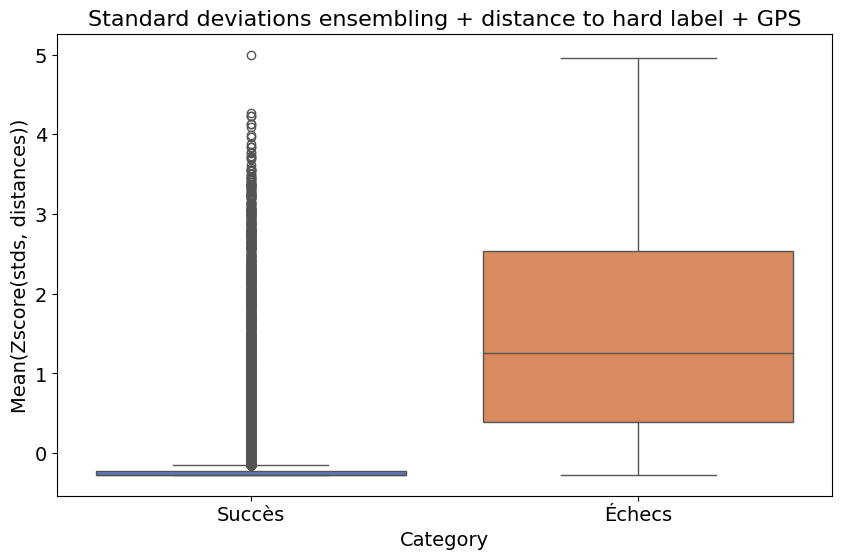

In [63]:
uq.UQ_method_plot([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions], 'Mean(Zscore(stds, distances))', 'Standard deviations ensembling + distance to hard label + GPS', swarmplot=False)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:405: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


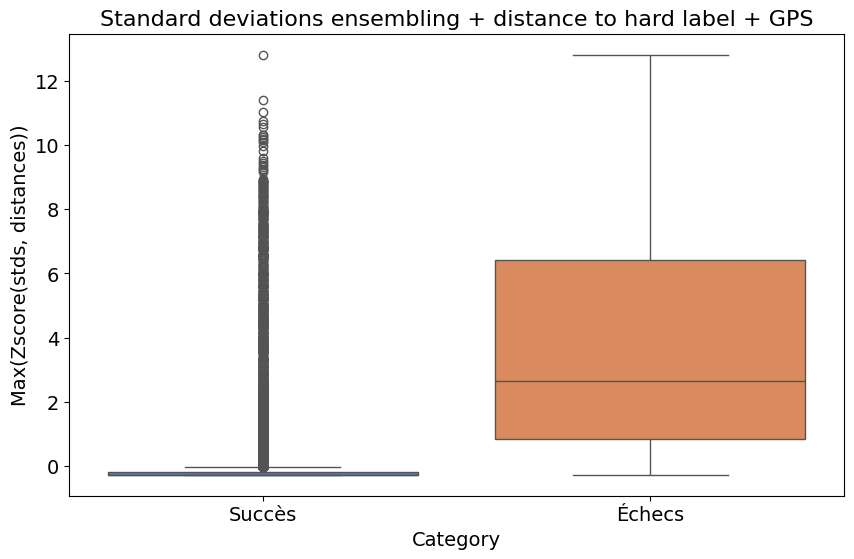

In [64]:
uq.UQ_method_plot([max_values[k] for k in correct_predictions], [max_values[j] for j in incorrect_predictions], 'Max(Zscore(stds, distances))', 'Standard deviations ensembling + distance to hard label + GPS', swarmplot=False)

In [102]:
fpr_comb, tpr_comb, auc_comb = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])

In [103]:
fpr_comb_max, tpr_comb_max, auc_comb_max = uq.roc_curve_UQ_method_computation([max_values[k] for k in correct_predictions], [max_values[j] for j in incorrect_predictions])

In [104]:
auc_comb

np.float64(0.9796940715193939)

In [105]:
auc_comb_max

np.float64(0.9796481971312295)

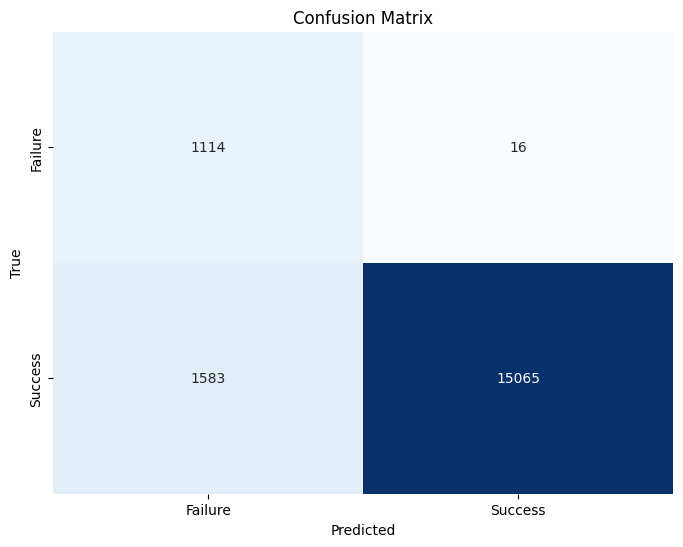

Optimal Threshold: -0.05601414044675737
Balanced Accuracy: 0.9453771055440501
Specificity: 0.9858407079646018
Sensitivity: 0.9049135031234983


In [109]:
find_best_threshold_and_compute_metrics(mean_values, correct_predictions)

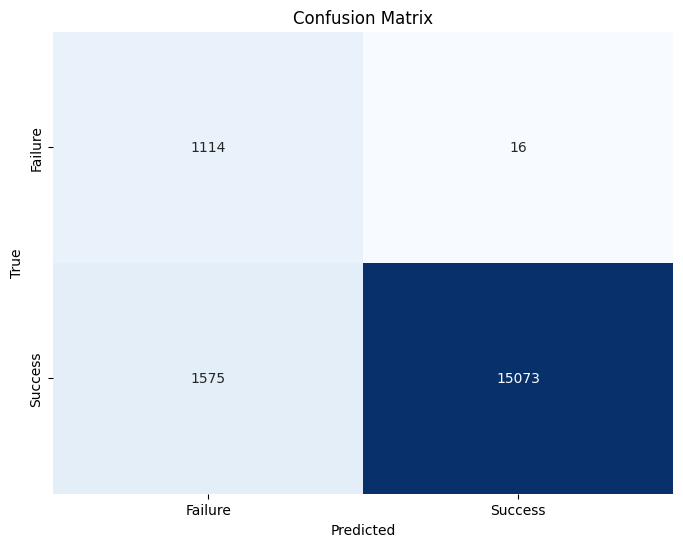

Optimal Threshold: 0.13213816363370035
Balanced Accuracy: 0.9456173746454436
Specificity: 0.9858407079646018
Sensitivity: 0.9053940413262854


In [110]:
find_best_threshold_and_compute_metrics(max_values, correct_predictions)

In [113]:
from sklearn.linear_model import Perceptron
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Prepare the calibration data
X_calibration = np.column_stack((stds_GPS_calibration, distances_calibration, stds_calibration, mean_knn_distances_calibration))
y_calibration = np.array([1 if i in correct_predictions_calibration else 0 for i in range(len(mean_knn_distances_calibration))])

class_weights = compute_class_weight('balanced', classes=np.unique(y_calibration), y=y_calibration)
class_weight_dict = {0: class_weights[1], 1: class_weights[0]}

# Prepare the test data
X_test = np.column_stack((stds_GPS, distances, stds, mean_knn_distances))

# Create a perceptron model with a standard scaler
perceptron = make_pipeline(StandardScaler(), Perceptron(class_weight=class_weight_dict))

# Train the perceptron on the calibration data
perceptron.fit(X_calibration, y_calibration)

# Get the scores for all test data
test_scores = perceptron.decision_function(X_test)

# Print the test scores
print(test_scores)

[11274.22202347   313.55735973   232.18863746 ... 34783.93299261
 15716.95717355  4850.50010555]


In [114]:
fpr_percep, tpr_percep, auc_percep = uq.roc_curve_UQ_method_computation([test_scores[k] for k in correct_predictions], [test_scores[j] for j in incorrect_predictions])

In [115]:
auc_percep

np.float64(0.974491288650368)

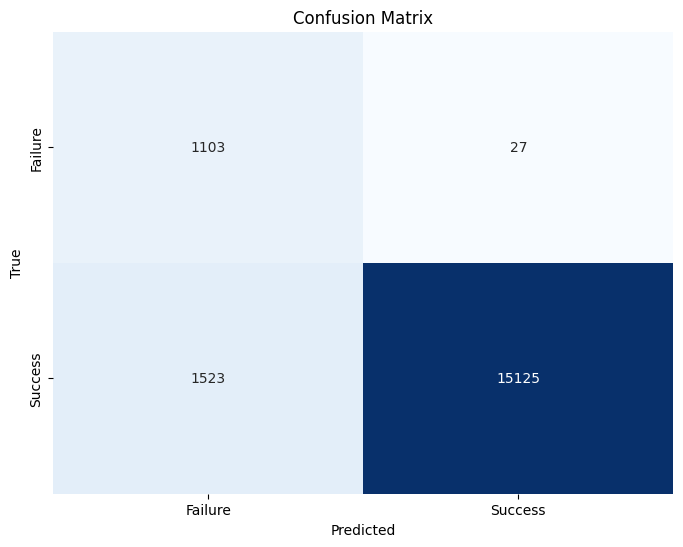

Optimal Threshold: 24817.69349656988
Balanced Accuracy: 0.9423118671673336
Specificity: 0.9761061946902655
Sensitivity: 0.9085175396444017


In [116]:
find_best_threshold_and_compute_metrics(test_scores, correct_predictions)

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import itertools

# Define the metrics
metrics = {
    "Dist to HL": distances,
    "Std": stds
}

# Define the labels
labels = np.array([1 if i in correct_predictions else 0 for i in range(len(mean_values))])

# Function to compute metrics
def compute_metrics(uq_values, labels, threshold):
    predictions = (uq_values <= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = balanced_accuracy_score(labels, predictions)
    return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

# Function to find the optimal threshold
def find_optimal_threshold(uq_values, labels, max_fp_rate=0.001):
    thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
    best_threshold = thresholds[0]
    best_tp = 0
    total_cases = len(labels)
    max_fp = total_cases * max_fp_rate
    for threshold in thresholds:
        tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
        if fp <= max_fp and tp > best_tp:
            best_tp = tp
            best_threshold = threshold
    return best_threshold

# Function to summarize results
def summarize_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    total_cases = len(labels)
    tp_proportion = tp / total_cases
    fp_proportion = fp / total_cases
    return tp, tp_proportion, fp, fp_proportion

def display_confusion_matrix_success_flags_prop(cm):
    # Convert cm to a Pandas DataFrame
    df_cm = pd.DataFrame(cm, index=['Failures', 'Success'], columns=['Failures', 'Success'])

    # Convert to proportions (normalize by total sum)
    cm_proportions = (cm.astype(np.float64) / cm.sum()) * 100  # Convert to percentage
    cm_proportions = pd.DataFrame(cm_proportions, index=df_cm.index, columns=df_cm.columns)  # Convert to DataFrame

    # Initialize annotations with the same shape as df_cm
    annotations = df_cm.copy().astype(str)

    # Add percentage values to the confusion matrix
    for i in range(df_cm.shape[0]):
        for j in range(df_cm.shape[1]):
            annotations.iloc[i, j] = f"{df_cm.iloc[i, j]} ({cm_proportions.iloc[i, j]:.1f}%)"

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=annotations, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 30})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
# Define a function to display the confusion matrix and metrics
def display_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    cm = confusion_matrix(labels, (uq_values <= threshold).astype(int))
    display_confusion_matrix_success_flags_prop(cm)
    print(f"Threshold: {threshold}")
    print(f"Specificity (TNR): {specificity:.2f}")
    print(f"Sensitivity (TPR): {sensitivity:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

# Create a DataFrame to store the results
results = []

# Perform ablation study for each metric separately
for metric_name, uq_values in metrics.items():
    best_threshold = find_optimal_threshold(uq_values, labels)
    tp, tp_proportion, fp, fp_proportion = summarize_results(uq_values, labels, best_threshold)
    results.append([metric_name, f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
    display_results(uq_values, labels, best_threshold)

# Perform ablation study for combinations of metrics
for r in range(2, len(metrics) + 1):
    for combination in itertools.combinations(metrics.keys(), r):
        combined_uq_values = uq.standardize_and_mean_ensembling(np.column_stack([metrics[key] for key in combination]))
        best_threshold = find_optimal_threshold(combined_uq_values, labels)
        tp, tp_proportion, fp, fp_proportion = summarize_results(combined_uq_values, labels, best_threshold)
        results.append([", ".join(combination), f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
        display_results(combined_uq_values, labels, best_threshold)

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Metric(s)", "TP (Count, Proportion)", "FP (Count, Proportion)"])

# Display the results
print(results_df)